# Read FreeSolv data

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [293]:
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

In [3]:
df = pd.read_csv("freesolv_NN_rep3dim.csv")

In [4]:
df

,x1,x2,x3,cal,expt
0,0.355909,0.654990,0.760502,9.625,11.01
1,0.188700,0.781979,0.410327,6.219,4.87
2,0.136415,0.281362,0.311954,-2.452,-1.83
3,0.166449,0.426157,0.586308,5.809,5.45
4,0.184554,0.270052,0.368473,2.917,4.21
...,...,...,...,...,...
637,0.281174,0.263573,0.442100,3.035,2.04
638,0.074772,0.481870,0.573542,4.278,5.48
639,0.251953,0.554530,0.741771,10.050,8.83
640,0.227589,0.085155,0.368976,-1.467,-0.29


# Useful functions

In [5]:
import numpy
import torch
import gpytorch
from torch import Tensor

from botorch.models import FixedNoiseGP
from botorch.models.transforms import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

In [6]:
def fit_gp_model(X, Y, Yvar=None):
    if X.ndim == 1:
        X = X.unsqueeze(dim=-1)
    if Y.ndim == 1:
        Y = Y.unsqueeze(dim=-1)
    model = FixedNoiseGP(X, Y, torch.ones(Y.shape) * 1e-4, outcome_transform=Standardize(m=Y.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

In [7]:
from torch.autograd import (Function, grad)
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.models.model import Model
from botorch.acquisition.analytic import (_scaled_improvement, _ei_helper)
from botorch.acquisition.objective import PosteriorTransform
from typing import Dict, Optional, Tuple, Union
from botorch.utils.transforms import t_batch_mode_transform
from botorch.utils.probability.utils import (
    ndtr as Phi,
    phi,
)

In [8]:
class GittinsIndexFunction(Function):
    @staticmethod
    def forward(X: torch.Tensor, mean: torch.Tensor, sigma: torch.Tensor, cost: float, maximize: bool, bounds: torch.Tensor, eps: float):
        
        def cost_adjusted_expected_improvement(best_f):
            u = _scaled_improvement(mean, sigma, best_f, maximize)
            return sigma * _ei_helper(u) - cost

        size = X.size()[0]
        l = bounds[0]*torch.ones(size)
        h = bounds[1]*torch.ones(size)
        m = (h + l) / 2

        if maximize:
            while torch.any(cost_adjusted_expected_improvement(best_f=l) < 0):
                l = 2 * l
            while torch.any(cost_adjusted_expected_improvement(best_f=h) > 0):
                h = 2 * h
        else:
            while torch.any(cost_adjusted_expected_improvement(best_f=l) > 0):
                l = 2 * l
            while torch.any(cost_adjusted_expected_improvement(best_f=h) < 0):
                h = 2 * h

        # Bisection method
#         while torch.max(torch.abs(cost_adjusted_expected_improvement(best_f=m))) >= eps:
        for _ in range(100):
            sgn_m = torch.sign(cost_adjusted_expected_improvement(best_f=m))
            if maximize:
                l = torch.where(sgn_m >= 0, m, l)
                h = torch.where(sgn_m <= 0, m, h)
            else:
                l = torch.where(sgn_m <= 0, m, l)
                h = torch.where(sgn_m >= 0, m, h)
            m = (h + l) / 2
            
        return m
    
    @staticmethod
    def setup_context(ctx, inputs, output):
        X, mean, sigma, cost, maximize, bounds, eps = inputs
        
        # Save u for backward computation
        u = _scaled_improvement(mean, sigma, output, maximize)
        
        # Save values needed in the backward pass
        ctx.save_for_backward(X, mean, sigma, u)
        
        # Save boolean flag directly in ctx
        ctx.maximize = maximize  

    @staticmethod
    def backward(ctx, grad_output):
                
        # Retrieve saved tensors
        X, mean, sigma, u = ctx.saved_tensors
        maximize = ctx.maximize  # Retrieve the boolean flag directly from ctx
                
        # Gradient of mean function with respect to x
        dmean_dX = grad(outputs=mean, inputs=X, grad_outputs=torch.ones_like(mean), retain_graph=True, allow_unused=True)[0].clone()

        # Gradient of the std function with respect to x
        dsigma_dX = grad(outputs=sigma, inputs=X, grad_outputs=torch.ones_like(sigma), retain_graph=True, allow_unused=True)[0].clone()
        
        # Check if gradients are None and handle accordingly
        if dmean_dX is None or dsigma_dX is None:
            raise RuntimeError("Gradients could not be computed for one or more components.")
        
        # Compute the gradient of the Gittins acquisition function
        if maximize:
            grad_X = grad_output.unsqueeze(-1).unsqueeze(-1) * (dmean_dX + phi(u).unsqueeze(-1).unsqueeze(-1) * dsigma_dX / Phi(u).unsqueeze(-1).unsqueeze(-1))
        else:
            grad_X = grad_output.unsqueeze(-1).unsqueeze(-1) * (dmean_dX - phi(u).unsqueeze(-1).unsqueeze(-1) * dsigma_dX / Phi(u).unsqueeze(-1).unsqueeze(-1))

        return grad_X, None, None, None, None, None, None

In [9]:
class GittinsIndex(AnalyticAcquisitionFunction):
    r"""Single-outcome Gittins Index (analytic).

    Computes Gittins index using the analytic formula for a Normal posterior distribution. Unlike the
    MC-based acquisition functions, this relies on the posterior at single test
    point being Gaussian (and require the posterior to implement `mean` and
    `variance` properties). Only supports the case of `q=1`. The model must be
    single-outcome.

    `GI(x) = argmin_g |E(max(f(x) - g, 0))-cost|,`

    where the expectation is taken over the value of stochastic function `f` at `x`.

    Example:
        >>> model = SingleTaskGP(train_X, train_Y)
        >>> GI = GittinsIndex(model, cost=0.05)
        >>> gi = GI(test_X)
        
    """

    def __init__(
        self,
        model: Model,
        cost: float,
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        bounds: torch.Tensor = torch.tensor([[-1.0], [1.0]], dtype=torch.float64),
        eps: float = 1e-6
    ):
        r"""Single-outcome Gittins Index (analytic).
        
        Args:
            model: A fitted single-outcome model.
            cost: Either a scalar or a `b`-dim Tensor (batch mode) representing
                the cost function.
            posterior_transform: A PosteriorTransform. If using a multi-output model,
                a PosteriorTransform that transforms the multi-output posterior into a
                single-output posterior is required.
            maximize: If True, consider the problem a maximization problem.
            bounds: A `2 x d` tensor of lower and upper bounds for each column of `X`.
        """
        super().__init__(model=model, posterior_transform=posterior_transform)
        self.cost = cost
        self.maximize = maximize
        self.bounds = bounds
        self.eps = eps
      
        
    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:
        r"""Evaluate Gittins Index on the candidate set X using bisection method.

        Args:
            X: A `(b1 x ... bk) x 1 x d`-dim batched tensor of `d`-dim design points.
                Gittins Index is computed for each point individually,
                i.e., what is considered are the marginal posteriors, not the joint.

        Returns:
            A `(b1 x ... bk)`-dim tensor of Gittins Index values at the
            given design points `X`.
        """
        
        mean, sigma = self._mean_and_sigma(X)
#         mean = self.model.posterior(X).mean.squeeze(-2).squeeze(-1)
#         sigma = self.model.posterior(X).variance.sqrt().squeeze(-2).squeeze(-1)
            
        return GittinsIndexFunction.apply(X, mean, sigma, self.cost, self.maximize, self.bounds, self.eps)

## Test 3D BayesOPT (x=df[["x1", "x2", "x3"]], y=df["energy"])

In [10]:
data_x_3D = torch.tensor(df[["x1", "x2", "x3"]].values, dtype=torch.float64)
data_x_3D

tensor([[0.3559, 0.6550, 0.7605],
        [0.1887, 0.7820, 0.4103],
        [0.1364, 0.2814, 0.3120],
        ...,
        [0.2520, 0.5545, 0.7418],
        [0.2276, 0.0852, 0.3690],
        [0.1053, 0.5603, 0.4798]], dtype=torch.float64)

In [11]:
data_y = torch.tensor(df["expt"], dtype=torch.float64)
data_y

tensor([ 1.1010e+01,  4.8700e+00, -1.8300e+00,  5.4500e+00,  4.2100e+00,
         6.2700e+00, -2.3400e+00,  3.9200e+00, -1.5800e+00,  4.6200e+00,
         1.9600e+00,  3.8800e+00,  4.3300e+00,  2.4900e+00,  2.5500e+00,
         4.7800e+00,  1.4600e+00,  2.2200e+00,  5.8500e+00, -2.8800e+00,
         6.3400e+00,  6.1000e+00,  5.4800e+00,  4.1000e+00,  4.1000e+00,
         3.5200e+00,  4.4700e+00,  2.7400e+00,  3.4300e+00,  7.8100e+00,
         8.0000e-01, -9.3000e-01,  6.7800e+00,  9.2900e+00,  4.0700e+00,
         5.9100e+00,  2.1300e+00,  3.6400e+00,  2.6800e+00, -3.1300e+00,
         1.0000e+01, -2.0600e+00,  8.1100e+00,  1.1200e+00,  2.3620e+01,
         2.8300e+00,  4.6800e+00,  5.5600e+00,  3.6500e+00,  5.4900e+00,
        -3.1200e+00,  4.4200e+00,  6.2000e+00,  6.9600e+00,  1.6000e-01,
         2.5000e-01,  9.3000e+00,  4.6300e+00,  1.0220e+01,  3.5600e+00,
         3.6500e+00,  4.2900e+00, -1.0700e+00,  9.5100e+00,  2.3000e-01,
         1.1000e-01,  1.6430e+01, -5.6000e-01,  3.2

In [13]:
# Fit the GP model using the data
objective_3D = fit_gp_model(data_x_3D, data_y, Yvar=None)

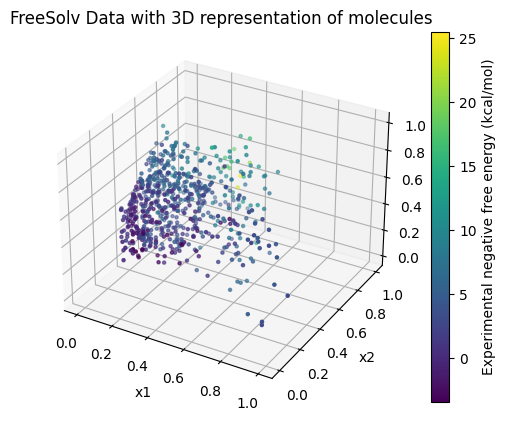

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Create a 3D scatter plot with color representing objective_y
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color representing objective_y
scatter = ax.scatter(data_x_3D[:, 0].numpy(), data_x_3D[:, 1].numpy(), data_x_3D[:, 2].numpy(), c=data_y.numpy(), cmap=cm.viridis, marker='.')

# Set axis labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

# Set colorbar
cbar = fig.colorbar(scatter)
cbar.set_label('Experimental negative free energy (kcal/mol)')

# Set plot title
ax.set_title('FreeSolv Data with 3D representation of molecules')

# Show the plot
plt.show()

In [151]:
import numpy as np

# Define the 3D grid over which you want to evaluate the GP model
x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_grid = torch.tensor(np.vstack([X1.ravel(), X2.ravel(), X3.ravel()]).T, dtype=torch.float)

# Fit the GP model using the data
objective_3D = fit_gp_model(data_x_3D, data_y, Yvar=None)

# Evaluate the GP model at the grid points
objective_3D.eval()  # Make sure the model is in evaluation mode
with torch.no_grad():
    posterior = objective_3D.posterior(X_grid)

In [152]:
X_grid

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0204],
        [0.0000, 0.0000, 0.0408],
        ...,
        [1.0000, 1.0000, 0.9592],
        [1.0000, 1.0000, 0.9796],
        [1.0000, 1.0000, 1.0000]])

/var/folders/7t/vmwdn0kn1cl6zhvm7j0pdljh0000gn/T/ipykernel_39457/1014700473.py:13: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  data_scatter = ax.scatter(data_x_3D[:, 0].numpy(), data_x_3D[:, 1].numpy(), data_x_3D[:, 2].numpy(),


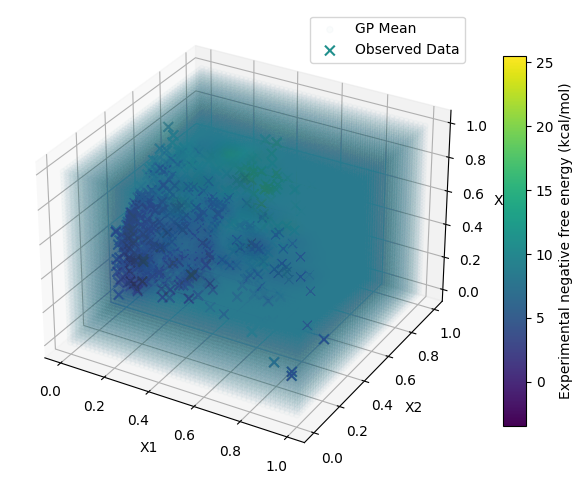

In [42]:
# Assuming observed_X and observed_Y are your observed data points and their corresponding outputs
# They should be tensors or arrays of shape [num_points, 3] and [num_points, 1], respectively

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the mean predictions as a color-coded scatter plot
mean_scatter = ax.scatter(X1.flatten(), X2.flatten(), X3.flatten(), c=posterior.mean.numpy(), cmap="viridis", alpha=0.02, label='GP Mean')

# Plot the observed data points
# Note: You may need to adjust the indexing and reshaping depending on your data structure
data_scatter = ax.scatter(data_x_3D[:, 0].numpy(), data_x_3D[:, 1].numpy(), data_x_3D[:, 2].numpy(),
                          c=data_y.numpy(), cmap="viridis", marker='x', s=50, edgecolors='w', label='Observed Data')

# Optionally, you can plot the confidence intervals as well (this may clutter the plot)

# Create a color bar for the mean predictions
cbar = fig.colorbar(data_scatter, shrink=0.8, aspect=16)
cbar.set_label('Experimental negative free energy (kcal/mol)')

# Set axis labels
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

# Legend
ax.legend()

plt.show()

In [152]:
objective_3D_mean = objective_3D.posterior(X_grid).mean
objective_3D_mean

tensor([[4.6237],
        [4.6237],
        [4.6237],
        ...,
        [4.6237],
        [4.6237],
        [4.6237]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)

In [153]:
objective_3D_std = objective_3D.posterior(X_grid).variance.sqrt()
objective_3D_std

tensor([[3.9179],
        [3.9179],
        [3.9179],
        ...,
        [3.9179],
        [3.9179],
        [3.9179]], dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [154]:
objective_3D_mean.max()

tensor(23.3125, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [155]:
objective_3D_mean.min()

tensor(-8.3628, dtype=torch.float64, grad_fn=<MinBackward1>)

In [156]:
objective_3D_std.max()

tensor(3.9179, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [157]:
objective_3D_std.min()

tensor(0.1295, dtype=torch.float64, grad_fn=<MinBackward1>)

In [101]:
def plot_data(data_x_3D,data_y,observed_x,observed_y,new_point,new_value):

    # Scatter a 3D plot with color representing objective_y and observed_y
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data_x_3D[:, 0].numpy(), data_x_3D[:, 1].numpy(), data_x_3D[:, 2].numpy(), c=data_y.numpy(), cmap=cm.viridis, marker='.')

    # Add the observed points with marker 'x'
    ax.scatter(observed_x[:, 0].detach().numpy(), observed_x[:, 1].detach().numpy(), observed_x[:, 2].detach().numpy(), c=observed_y.detach().numpy(), cmap=cm.viridis, marker='x', s=50)
    
    # Add the new point with marker '*'
    ax.scatter(new_point[0, 0].numpy(), new_point[0, 1].numpy(), new_point[0, 2].numpy(), c=new_value.detach().numpy(), cmap=cm.viridis, marker='*', s=50)
    
    # Set axis labels
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')

    # Set colorbar
    cbar = fig.colorbar(scatter)
    cbar.set_label('Experimental negative free energy (kcal/mol)')

In [102]:
def plot_acq(acq,data_x_3D,new_point,new_point_acq):

    # Scatter a 3D plot with color representing acq
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data_x_3D[:, 0].numpy(), data_x_3D[:, 1].numpy(), data_x_3D[:, 2].numpy(), c=acq.detach().numpy(), cmap=cm.viridis, marker='.')

    # Add the new point with marker '*'
    ax.scatter(new_point[0, 0].numpy(), new_point[0, 1].numpy(), new_point[0, 2].numpy(), c=new_point_acq.detach().numpy(), marker='*', s=50)
    
    # Set axis labels
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')

    # Set colorbar
    cbar = fig.colorbar(scatter)
    cbar.set_label('Acquisition function')
    plt.show()

In [294]:
from botorch.models.transforms.outcome import Standardize
from botorch.utils.sampling import draw_sobol_samples

# Specify the number of dimensions
d = 3  # You can change this to any number of dimensions you need

# Define the bounds of your d-dimensional hypercube
lower_bounds = torch.zeros(d)
upper_bounds = torch.ones(d)

# Define the bounds of your cube (e.g., a unit cube in 3D space)
bounds = torch.stack([lower_bounds, upper_bounds])

# Number of points to sample
n_points = 2*(d+1)

# Generate points using Sobol sequences
sobol_points = draw_sobol_samples(bounds=bounds, n=1, q=n_points, seed=42).squeeze(0).requires_grad_(True)

# The points are now stored in sobol_points
print(sobol_points)

tensor([[0.9975, 0.1044, 0.8230],
        [0.4194, 0.5283, 0.0562],
        [0.4553, 0.7492, 0.2211],
        [0.6177, 0.8101, 0.2123],
        [0.0384, 0.8818, 0.6506],
        [0.6666, 0.8209, 0.5966],
        [0.2363, 0.8070, 0.1671],
        [0.7678, 0.6035, 0.9326]], requires_grad=True)


In [295]:
objective_3D.posterior(sobol_points).mean

tensor([[4.6237],
        [4.6573],
        [4.7119],
        [4.6588],
        [4.6224],
        [5.0738],
        [4.6321],
        [4.6243]], grad_fn=<UnsqueezeBackward0>)

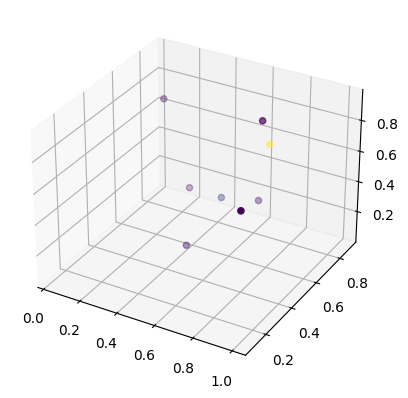

In [296]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sobol_points[:,0].detach().numpy(), sobol_points[:,1].detach().numpy(), sobol_points[:,2].detach().numpy(), c=objective_3D.posterior(sobol_points).mean.detach().numpy())

In [297]:
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

seed = 42

torch.manual_seed(seed)

maximize = True 

num_iterations = 60

# Specify the number of dimensions
d = 3  # You can change this to any number of dimensions you need

# Define the bounds of your d-dimensional hypercube
lower_bounds = torch.zeros(d)
upper_bounds = torch.ones(d)

# Define the bounds of your cube (e.g., a unit cube in 3D space)
bounds = torch.stack([lower_bounds, upper_bounds])

# Number of points to sample
n_points = 2*(d+1)

# Generate points using Sobol sequences
x = draw_sobol_samples(bounds=bounds, n=1, q=n_points, seed=seed).squeeze(0).requires_grad_(True)
y = objective_3D.posterior(x).mean  # add output dimension

if maximize:
    best_f = y.max().item() 
else:
    best_f = y.min().item() 
    
EI_best = [best_f] # This will store the best values over iterations
    
EI_acq = [] # This will store the EI acq values over iterations

for i in range(num_iterations):
    
    # Fit the model
    model = fit_gp_model(x.detach(), y.detach(), Yvar=None)
            
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)
    
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=bounds,
        q=1,
        num_restarts=10*d,
        raw_samples=100*d,
        options={},
    )
    
    new_value = objective_3D.posterior(new_point).mean
    
    print("Iteration:", i)
    print("best oberved value:", best_f)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    print("new acq:", new_point_EI.item())
    
#     acq = BoTorch_EI.forward(data_x_3D.unsqueeze(1))
#     plot_data(data_x_3D,data_y,x,y,new_point,new_value)
#     plot_acq(acq,data_x_3D,new_point,new_point_EI)
    
    #cross_validation(x,y,nu=0.5)
    
    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y,new_value))
    EI_acq.append(new_point_EI.item())
    
    # Update the best observed value
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EI_best.append(best_f)
    print()

Iteration: 0
best oberved value: 5.073772685985185
new point: [[0.75584081 0.93310303 0.58237508]]
new value: 4.63738231918268
new acq: 0.017011917242634345

Iteration: 1
best oberved value: 5.073772685985185
new point: [[0.67901882 0.78912206 0.62614922]]
new value: 4.827990549222701
new acq: 0.023138649732425288

Iteration: 2
best oberved value: 5.073772685985185
new point: [[0.660783   0.83693323 0.58510687]]
new value: 5.282670735603322
new acq: 0.021237649950455635

Iteration: 3
best oberved value: 5.282670735603322
new point: [[0.64681725 0.84508539 0.57402477]]
new value: 5.624337689627479
new acq: 0.07548968206949513

Iteration: 4
best oberved value: 5.624337689627479
new point: [[0.64065161 0.92674821 0.58282368]]
new value: 5.339451004731966
new acq: 0.03921568373161112

Iteration: 5
best oberved value: 5.624337689627479
new point: [[0.62024721 0.80784178 0.55772865]]
new value: 5.538665468702288
new acq: 0.253440945405525

Iteration: 6
best oberved value: 5.624337689627479
n

Iteration: 54
best oberved value: 20.54559277547411
new point: [[0.17713241 0.8320754  0.76837055]]
new value: 4.733007266504307
new acq: 1.891272866951246e-08

Iteration: 55
best oberved value: 20.54559277547411
new point: [[0.47615869 0.98984558 0.61505343]]
new value: 5.0399494070959
new acq: 3.68826883806098e-08

Iteration: 56
best oberved value: 20.54559277547411
new point: [[0.44840517 0.50055757 0.74113728]]
new value: 4.063523567035675
new acq: 7.516229119236758e-09

Iteration: 57
best oberved value: 20.54559277547411
new point: [[0.15943677 0.75875059 0.54549289]]
new value: 5.307631217025291
new acq: 6.226646125130095e-09

Iteration: 58
best oberved value: 20.54559277547411
new point: [[0.30201259 0.74826573 0.60590644]]
new value: 12.095506602425694
new acq: 8.195486505867236e-09

Iteration: 59
best oberved value: 20.54559277547411
new point: [[0.35271711 0.82070522 0.58389166]]
new value: 16.903981217434254
new acq: 1.9049039336713914e-08



Text(0.5, 1.0, 'Performance of EI policy')

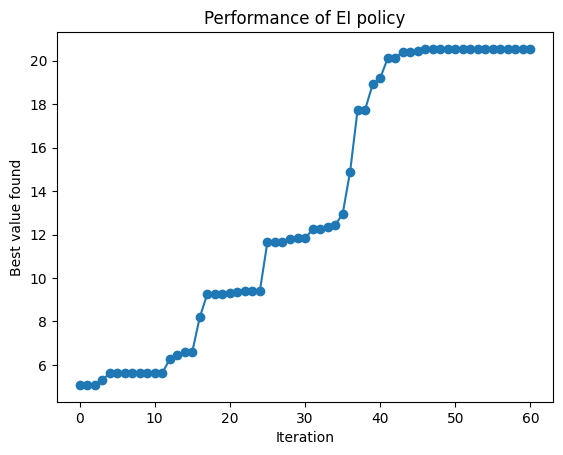

In [298]:
plt.plot(EI_best,'o-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy")

In [236]:
GI_best_dict = {}  # This dict will store the best-value arrays for different cost parameters
GI_acq_dict = {}  # This dict will store the acq arrays for different cost parameters

In [299]:
def test_Gittins(seed, num_dimensions, maximize, cost, num_iterations, GI_best_dict, GI_acq_dict):
    
    torch.manual_seed(seed) 
    
    d = num_dimensions

    # Define the bounds of your d-dimensional hypercube
    lower_bounds = torch.zeros(d)
    upper_bounds = torch.ones(d)

    # Define the bounds of your cube (e.g., a unit cube in 3D space)
    bounds = torch.stack([lower_bounds, upper_bounds])

    # Number of points to sample
    n_points = 2*(d+1)

    # Generate points using Sobol sequences
    x = draw_sobol_samples(bounds=bounds, n=1, q=n_points, seed=seed).squeeze(0).requires_grad_(True)
    y = objective_3D.posterior(x).mean  # add output dimension

    if maximize:
        best_f = y.max().item() 
    else:
        best_f = y.min().item() 

    GI_best = [best_f]  # This will store the best values over iterations
    GI_acq = []  # This will store the Gittins index of the new observation over iterations

    for i in range(num_iterations):
        
        # Fit the model
        model = fit_gp_model(x.detach(), y.detach(), Yvar=None)

        # Find the optimal Gittins index value of the initial observations
        GI = GittinsIndex(model=model, cost=cost, maximize=maximize)

        if maximize:
            new_point, new_point_GI = optimize_acqf(
                acq_function=GI,
                bounds=bounds,
                q=1,
                num_restarts=10*d,
                raw_samples=100*d,
                options={},
            )
        else:
            neg_GI = lambda X: -GI(X)
            new_point, new_point_neg_GI = optimize_acqf(
                acq_function=neg_GI,
                bounds=bounds,
                q=1,
                num_restarts=10*d,
                raw_samples=100*d,
                options={},
            )
            new_point_GI = -new_point_neg_GI

        new_value = objective_3D.posterior(new_point).mean

        print("Iteration:", i)
        print("best oberved value:", best_f)
        print("new point:", new_point.detach().numpy())
        print("new value:", new_value.item())
        print("new acq:", new_point_GI.item())
        

        #cross_validation(x,y,nu=0.5)


        # Add the new data
        x = torch.cat((x,new_point))
        y = torch.cat((y,new_value))
        GI_acq.append(new_point_GI.item())

        if maximize:
            best_f = max(best_f, new_value.item())
        else:
            best_f = min(best_f, new_value.item())

        GI_best.append(best_f)
        print()
        
    GI_best_dict[cost] = GI_best
    GI_acq_dict[cost] = GI_acq

In [302]:
cost = 0.1
maximize = True
num_dimensions = 3
test_Gittins(seed=seed, num_dimensions=num_dimensions, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict, GI_acq_dict=GI_acq_dict)

Iteration: 0
best oberved value: 5.073772685985185
new point: [[0.67420061 0.82509664 0.58980633]]
new value: 5.005231666213666
new acq: 4.973112324826433

Iteration: 1
best oberved value: 5.073772685985185
new point: [[0.65954133 0.81039852 0.61118845]]
new value: 5.0744569053618624
new acq: 5.022301645278445

Iteration: 2
best oberved value: 5.0744569053618624
new point: [[0.66119496 0.82583615 0.59929314]]
new value: 5.170743597226695
new acq: 4.979008774752485

Iteration: 3
best oberved value: 5.170743597226695
new point: [[0.64585182 0.8513132  0.61074587]]
new value: 5.5301240863438395
new acq: 5.202051139348377

Iteration: 4
best oberved value: 5.5301240863438395
new point: [[0.61771602 0.89151755 0.63994992]]
new value: 5.190064893947954
new acq: 5.641332740987812

Iteration: 5
best oberved value: 5.5301240863438395
new point: [[0.64101668 0.85796275 0.61976148]]
new value: 5.460914331876391
new acq: 5.453543808118514

Iteration: 6
best oberved value: 5.5301240863438395
new poi

Iteration: 53
best oberved value: 9.423511912741201
new point: [[0.57531488 0.870168   0.58690151]]
new value: 9.423298370677358
new acq: 9.323264595683764

Iteration: 54
best oberved value: 9.423511912741201
new point: [[0.57531487 0.87016779 0.58690205]]
new value: 9.423304403419444
new acq: 9.323265687068368

Iteration: 55
best oberved value: 9.423511912741201
new point: [[0.57531525 0.87016811 0.58690161]]
new value: 9.423300991737353
new acq: 9.323266890533827

Iteration: 56
best oberved value: 9.423511912741201
new point: [[0.57531512 0.87016775 0.58690149]]
new value: 9.423298395401254
new acq: 9.323267917173563

Iteration: 57
best oberved value: 9.423511912741201
new point: [[0.5753158  0.87016781 0.58690204]]
new value: 9.423307288986157
new acq: 9.32326881945663

Iteration: 58
best oberved value: 9.423511912741201
new point: [[0.5753151  0.8701675  0.58690191]]
new value: 9.423302934515633
new acq: 9.323269916269044

Iteration: 59
best oberved value: 9.423511912741201
new poi

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.1)')

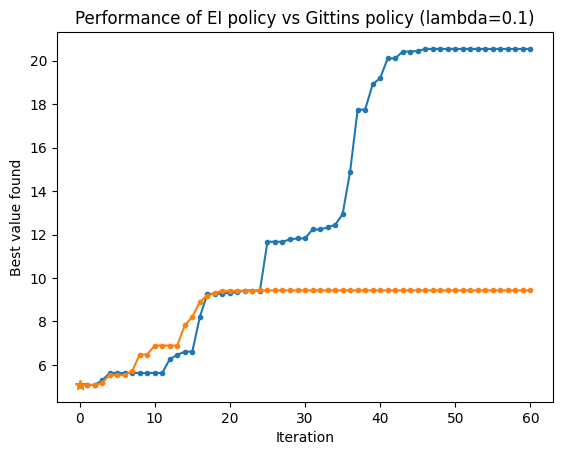

In [303]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
GI_stopping_time = np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0][0]
plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
plt.scatter(GI_stopping_time, GI_best_dict[cost][GI_stopping_time], c='orange', marker='*', s=50)
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={})".format(cost))

In [304]:
cost=0.05
maximize = True
num_dimensions = 3
test_Gittins(seed=seed, num_dimensions=num_dimensions, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict, GI_acq_dict=GI_acq_dict)

Iteration: 0
best oberved value: 5.073772685985185
new point: [[0.67422102 0.82510779 0.58979063]]
new value: 5.005041765280739
new acq: 5.0231127369386925

Iteration: 1
best oberved value: 5.073772685985185
new point: [[0.66446138 0.80696471 0.61445545]]
new value: 4.997531944325095
new acq: 5.079057743808784

Iteration: 2
best oberved value: 5.073772685985185
new point: [[0.65411388 0.83441726 0.58231553]]
new value: 5.394158399131774
new acq: 5.069666754115037

Iteration: 3
best oberved value: 5.394158399131774
new point: [[0.63447042 0.87293859 0.53999919]]
new value: 5.228668667586864
new acq: 5.59261705847047

Iteration: 4
best oberved value: 5.394158399131774
new point: [[0.64874282 0.84634246 0.56774681]]
new value: 5.495317386054945
new acq: 5.402578823622052

Iteration: 5
best oberved value: 5.495317386054945
new point: [[0.64882815 0.84924965 0.56224591]]
new value: 5.422277709583595
new acq: 5.446443852062494

Iteration: 6
best oberved value: 5.495317386054945
new point: [[

Iteration: 52
best oberved value: 10.250226363641662
new point: [[0.54920292 0.76285449 0.61453109]]
new value: 10.250054237764214
new acq: 10.200216168557866

Iteration: 53
best oberved value: 10.250226363641662
new point: [[0.54920326 0.76285366 0.61453018]]
new value: 10.250072222732204
new acq: 10.200208898563371

Iteration: 54
best oberved value: 10.250226363641662
new point: [[0.54920319 0.76285287 0.61453018]]
new value: 10.250078104385523
new acq: 10.200203027579871

Iteration: 55
best oberved value: 10.250226363641662
new point: [[0.5492032  0.76285188 0.61452995]]
new value: 10.250088611531599
new acq: 10.200197882304586

Iteration: 56
best oberved value: 10.250226363641662
new point: [[0.54920333 0.76285275 0.6145295 ]]
new value: 10.25008711744755
new acq: 10.200193559975691

Iteration: 57
best oberved value: 10.250226363641662
new point: [[0.54920328 0.76285147 0.61452978]]
new value: 10.25009394647914
new acq: 10.20018951517972

Iteration: 58
best oberved value: 10.250226

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.05)')

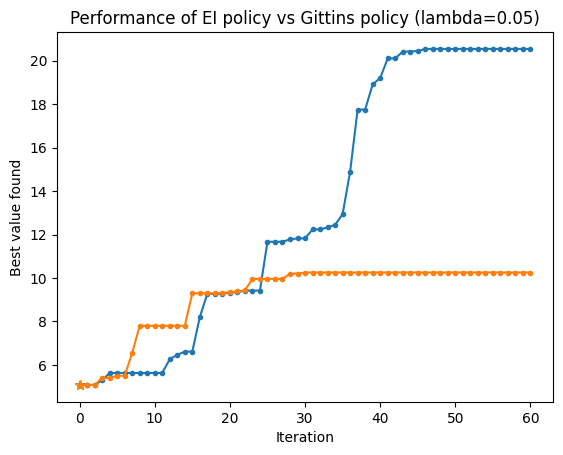

In [305]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
GI_stopping_time = np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0][0]
plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
plt.scatter(GI_stopping_time, GI_best_dict[cost][GI_stopping_time], c='orange', marker='*', s=50)
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={})".format(cost))

In [306]:
cost=0.01
maximize = True
num_dimensions = 3
test_Gittins(seed=seed, num_dimensions=num_dimensions, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict, GI_acq_dict=GI_acq_dict)

Iteration: 0
best oberved value: 5.073772685985185
new point: [[0.77216968 0.96939735 0.58652904]]
new value: 4.627474376089508
new acq: 5.103520247383344

Iteration: 1
best oberved value: 5.073772685985185
new point: [[0.68846844 0.76910858 0.61626335]]
new value: 4.783077519835446
new acq: 5.110804321292683

Iteration: 2
best oberved value: 5.073772685985185
new point: [[0.65755571 0.86251121 0.6429525 ]]
new value: 4.869305921064366
new acq: 5.095064527469436

Iteration: 3
best oberved value: 5.073772685985185
new point: [[0.66976305 0.77815097 0.50597541]]
new value: 4.977183883447849
new acq: 5.089236781785077

Iteration: 4
best oberved value: 5.073772685985185
new point: [[0.66826893 0.820564   0.50075654]]
new value: 4.889276917430945
new acq: 5.073861641932668

Iteration: 5
best oberved value: 5.073772685985185
new point: [[0.66684898 0.74068018 0.5928357 ]]
new value: 4.899619303258385
new acq: 5.128800902300087

Iteration: 6
best oberved value: 5.073772685985185
new point: [[

Iteration: 53
best oberved value: 25.591125701491553
new point: [[0.39219064 0.82518356 0.52029261]]
new value: 25.591124341239013
new acq: 25.581121762435345

Iteration: 54
best oberved value: 25.591125701491553
new point: [[0.39219082 0.82518414 0.52029239]]
new value: 25.591124336292634
new acq: 25.581121861065412

Iteration: 55
best oberved value: 25.591125701491553
new point: [[0.392191   0.82518359 0.52029192]]
new value: 25.591122987917515
new acq: 25.58112194742565

Iteration: 56
best oberved value: 25.591125701491553
new point: [[0.39219022 0.82518364 0.52029185]]
new value: 25.59112231777258
new acq: 25.58112196744237

Iteration: 57
best oberved value: 25.591125701491553
new point: [[0.39219117 0.82518366 0.52029186]]
new value: 25.59112300452988
new acq: 25.581121983931887

Iteration: 58
best oberved value: 25.591125701491553
new point: [[0.39219079 0.82518403 0.52029228]]
new value: 25.591123981319264
new acq: 25.581122017479856

Iteration: 59
best oberved value: 25.5911257

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.01)')

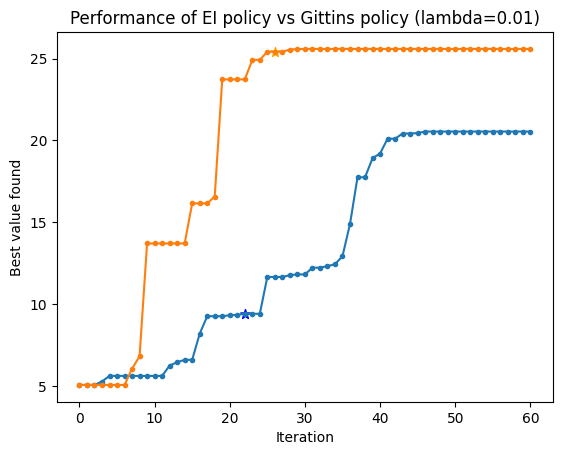

In [307]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
GI_stopping_time = np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0][0]
plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
plt.scatter(GI_stopping_time, GI_best_dict[cost][GI_stopping_time], c='orange', marker='*', s=50)
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={})".format(cost))

In [308]:
cost=0.005
maximize = True
num_dimensions = 3
test_Gittins(seed=seed, num_dimensions=num_dimensions, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict, GI_acq_dict=GI_acq_dict)

Iteration: 0
best oberved value: 5.073772685985185
new point: [[0.79232281 1.         0.59010397]]
new value: 4.62456024845864
new acq: 5.142184668718151

Iteration: 1
best oberved value: 5.073772685985185
new point: [[0.68942152 0.74986577 0.58999786]]
new value: 4.757727048204513
new acq: 5.139390282888458

Iteration: 2
best oberved value: 5.073772685985185
new point: [[0.73803143 0.84447611 0.66612   ]]
new value: 4.633403936628914
new acq: 5.125664021529577

Iteration: 3
best oberved value: 5.073772685985185
new point: [[0.65720527 0.87423384 0.6613473 ]]
new value: 4.73414039399832
new acq: 5.116238652128565

Iteration: 4
best oberved value: 5.073772685985185
new point: [[0.60820012 0.84776742 0.58132157]]
new value: 7.386563161171447
new acq: 5.135361284821057

Iteration: 5
best oberved value: 7.386563161171447
new point: [[0.5727042  0.81119643 0.53997682]]
new value: 6.548830424207827
new acq: 8.267424623006445

Iteration: 6
best oberved value: 7.386563161171447
new point: [[0.

Iteration: 53
best oberved value: 9.432448717540055
new point: [[0.57632189 0.87074518 0.58811102]]
new value: 9.43244829346079
new acq: 9.427336818280647

Iteration: 54
best oberved value: 9.432448717540055
new point: [[0.57632068 0.87074682 0.58811108]]
new value: 9.432447828308412
new acq: 9.427339970682624

Iteration: 55
best oberved value: 9.432448717540055
new point: [[0.57632165 0.870747   0.58811105]]
new value: 9.432447490909869
new acq: 9.427342935806358

Iteration: 56
best oberved value: 9.432448717540055
new point: [[0.57632    0.87074682 0.58810948]]
new value: 9.432448372711585
new acq: 9.427345729555839

Iteration: 57
best oberved value: 9.432448717540055
new point: [[0.57632023 0.87074672 0.58811072]]
new value: 9.432448080105043
new acq: 9.427348429338853

Iteration: 58
best oberved value: 9.432448717540055
new point: [[0.5763234  0.8707481  0.58811014]]
new value: 9.432446702503967
new acq: 9.427350967573524

Iteration: 59
best oberved value: 9.432448717540055
new poi

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.005)')

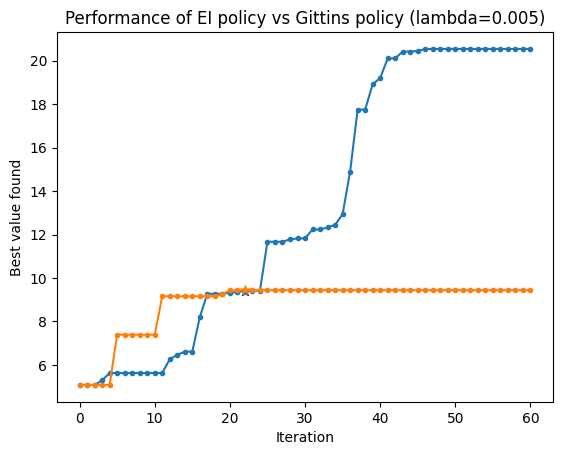

In [309]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
GI_stopping_time = np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0][0]
plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
plt.scatter(GI_stopping_time, GI_best_dict[cost][GI_stopping_time], c='orange', marker='*', s=50)
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={})".format(cost))

In [310]:
cost=0.001
maximize = True
num_dimensions = 3
test_Gittins(seed=seed, num_dimensions=num_dimensions, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict, GI_acq_dict=GI_acq_dict)

Iteration: 0
best oberved value: 5.073772685985185
new point: [[0.87087712 1.         0.59007568]]
new value: 4.623707178778885
new acq: 5.226823300121353

Iteration: 1
best oberved value: 5.073772685985185
new point: [[0.53729663 0.80504503 0.62133417]]
new value: 8.632385261805641
new acq: 5.232903271381673

Iteration: 2
best oberved value: 8.632385261805641
new point: [[0.47821107 0.82019684 0.77237997]]
new value: 5.280009240352457
new acq: 10.556465589084596

Iteration: 3
best oberved value: 8.632385261805641
new point: [[0.50574101 0.74111301 0.5368076 ]]
new value: 6.824033476185809
new acq: 10.16619609430429

Iteration: 4
best oberved value: 8.632385261805641
new point: [[0.52818567 1.         0.61688667]]
new value: 4.776279584013114
new acq: 9.860673457747342

Iteration: 5
best oberved value: 8.632385261805641
new point: [[0.55629076 0.74002349 0.65403509]]
new value: 6.774546038734199
new acq: 9.742780888734032

Iteration: 6
best oberved value: 8.632385261805641
new point: [

Iteration: 52
best oberved value: 25.590255874458368
new point: [[0.         0.01010852 0.75111721]]
new value: 4.623681125318927
new acq: 17.914484530478347

Iteration: 53
best oberved value: 25.590255874458368
new point: [[0.61095943 0.6136915  0.58040565]]
new value: 4.931514349467327
new acq: 17.736155874513855

Iteration: 54
best oberved value: 25.590255874458368
new point: [[0.39206172 0.82524664 0.52036939]]
new value: 25.59095128910094
new acq: 25.594137549393274

Iteration: 55
best oberved value: 25.59095128910094
new point: [[0.39213308 0.82524568 0.52037751]]
new value: 25.591106075268314
new acq: 25.593227716463332

Iteration: 56
best oberved value: 25.591106075268314
new point: [[1.         0.48778155 0.        ]]
new value: 4.623666659534711
new acq: 17.560346960012275

Iteration: 57
best oberved value: 25.591106075268314
new point: [[0.39217023 0.82523578 0.52038119]]
new value: 25.591157764937993
new acq: 25.59270007610062

Iteration: 58
best oberved value: 25.591157764

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.001)')

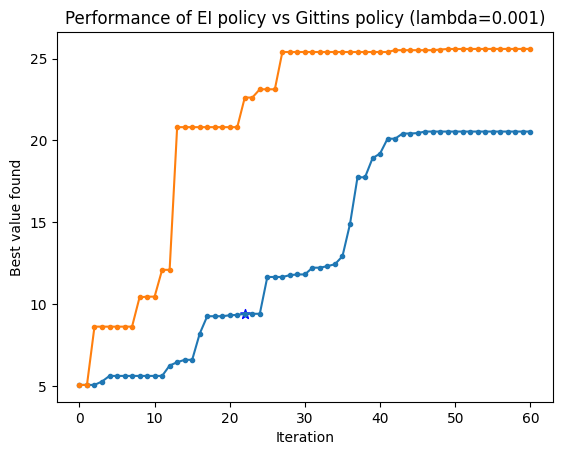

In [311]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={})".format(cost))

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy on FreeSolv Data')

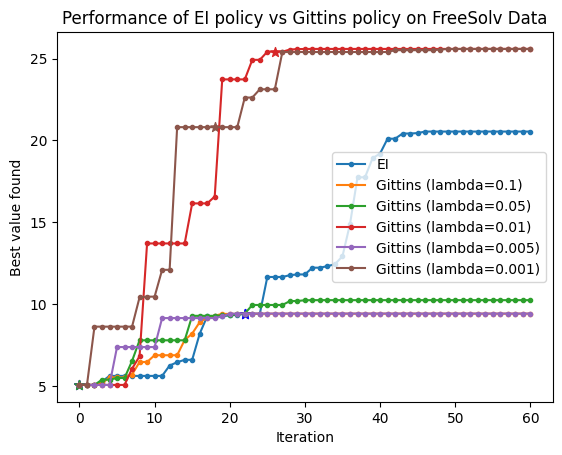

In [312]:
# Plotting EI
plt.plot(EI_best, '.-', label='EI')

# Plotting Gittins
for cost in sorted(GI_best_dict.keys(), reverse=True):
    EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
    plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
    line = plt.plot(GI_best_dict[cost], '.-', label="Gittins (lambda={})".format(cost))
    if np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0].size > 0:
        GI_stopping_time = np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0][0]
        plt.scatter(GI_stopping_time, GI_best_dict[cost][GI_stopping_time], c=line[0].get_color(), marker='*', s=50)

# Adding legend
plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy on FreeSolv Data")

In [251]:
UCB_best_dict = {}  # This dict will store the best-value arrays for different cost parameters
UCB_acq_dict = {}  # This dict will store the acq arrays for different cost parameters

In [313]:
from botorch.acquisition import UpperConfidenceBound

def test_UCB(seed, maximize, beta, num_iterations, UCB_best_dict, UCB_acq_dict):

    torch.manual_seed(seed)

    d = num_dimensions

    # Define the bounds of your d-dimensional hypercube
    lower_bounds = torch.zeros(d)
    upper_bounds = torch.ones(d)

    # Define the bounds of your cube (e.g., a unit cube in 3D space)
    bounds = torch.stack([lower_bounds, upper_bounds])

    # Number of points to sample
    n_points = 2*(d+1)

    # Generate points using Sobol sequences
    x = draw_sobol_samples(bounds=bounds, n=1, q=n_points, seed=seed).squeeze(0).requires_grad_(True)
    y = objective_3D.posterior(x).mean  # add output dimension

    if maximize:
        best_f = y.max().item() 
    else:
        best_f = y.min().item() 

    UCB_best = [best_f] # This will store the best values over iterations

    UCB_acq = [] # This will store the UCB acq values over iterations

    for i in range(num_iterations):

        # Fit the model
        model = fit_gp_model(x.detach(), y.detach(), Yvar=None)

        # Optimize UCB
        BoTorch_UCB = UpperConfidenceBound(model=model, beta=beta, maximize=maximize)

        new_point, new_point_UCB = optimize_acqf(
            acq_function=BoTorch_UCB,
            bounds=bounds,
            q=1,
            num_restarts=10*d,
            raw_samples=100*d,
            options={},
        )

        new_value = objective_3D.posterior(new_point).mean

        print("Iteration:", i)
        print("best oberved value:", best_f)
        print("new point:", new_point.detach().numpy())
        print("new value:", new_value.item())
        print("new acq:", new_point_UCB.item())
        print()

        #cross_validation(x,y,nu=0.5)

        # Add the new data
        x = torch.cat((x,new_point))
        y = torch.cat((y,new_value))
        UCB_acq.append(new_point_UCB.item())

        # Update the best observed value
        if maximize:
            best_f = max(best_f, new_value.item())
        else:
            best_f = min(best_f, new_value.item())

        UCB_best.append(best_f)
        
    UCB_best_dict[beta] = UCB_best
    UCB_acq_dict[beta] = UCB_acq

In [314]:
beta=2.72
maximize=True
test_UCB(seed=seed, maximize=maximize, beta=beta, num_iterations=num_iterations, UCB_best_dict=UCB_best_dict, UCB_acq_dict=UCB_acq_dict)

Iteration: 0
best oberved value: 5.073772685985185
new point: [[0.78083022 0.98934116 0.58883907]]
new value: 4.625431336441543
new acq: 5.179779737458239

Iteration: 1
best oberved value: 5.073772685985185
new point: [[0.69411853 0.75622974 0.59881198]]
new value: 4.74828656918441
new acq: 5.180536200940092

Iteration: 2
best oberved value: 5.073772685985185
new point: [[0.65630873 0.87511244 0.68633042]]
new value: 4.661399344337282
new acq: 5.1615721188105415

Iteration: 3
best oberved value: 5.073772685985185
new point: [[0.83683939 0.81313227 0.61531073]]
new value: 4.624277812632133
new acq: 5.143913704520393

Iteration: 4
best oberved value: 5.073772685985185
new point: [[0.62728736 0.81096981 0.60963294]]
new value: 5.621903073636643
new acq: 5.1487558086025365

Iteration: 5
best oberved value: 5.621903073636643
new point: [[0.60114146 0.80409506 0.59096803]]
new value: 5.944425544871988
new acq: 5.8607319472392145

Iteration: 6
best oberved value: 5.944425544871988
new point: 

Iteration: 53
best oberved value: 8.685596281133797
new point: [[0.55682246 0.77756233 0.51300485]]
new value: 8.685286362569446
new acq: 8.68841195721776

Iteration: 54
best oberved value: 8.685596281133797
new point: [[0.5582605  0.77737305 0.51260876]]
new value: 8.683963454383717
new acq: 8.688406112985556

Iteration: 55
best oberved value: 8.685596281133797
new point: [[0.55679418 0.77760548 0.51297898]]
new value: 8.685291890571865
new acq: 8.688342928533517

Iteration: 56
best oberved value: 8.685596281133797
new point: [[0.55770993 0.77844958 0.51302746]]
new value: 8.684510270837551
new acq: 8.688323505020417

Iteration: 57
best oberved value: 8.685596281133797
new point: [[0.55707853 0.77788738 0.51227649]]
new value: 8.684281468625274
new acq: 8.688313683015828

Iteration: 58
best oberved value: 8.685596281133797
new point: [[0.55821902 0.77736606 0.51267897]]
new value: 8.684156934563426
new acq: 8.688236743339989

Iteration: 59
best oberved value: 8.685596281133797
new poi

Text(0.5, 1.0, 'Performance of EI vs Gittins (lambda=0.005) vs UCB (beta=2.72)')

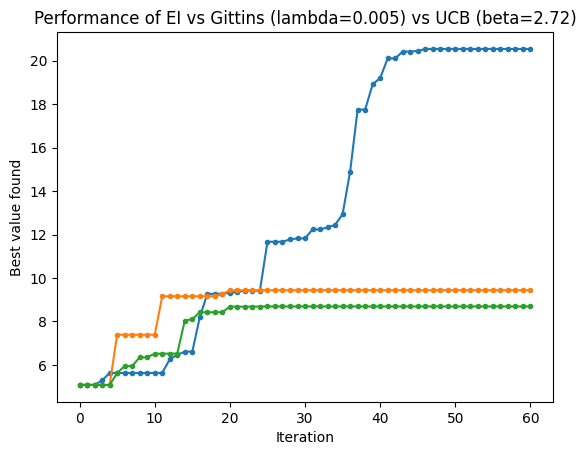

In [315]:
cost=0.005
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
plt.plot(UCB_best_dict[beta],'.-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI vs Gittins (lambda={}) vs UCB (beta={})".format(cost, beta))

In [316]:
beta=3.18
maximize=True
test_UCB(seed=seed, maximize=maximize, beta=beta, num_iterations=num_iterations, UCB_best_dict=UCB_best_dict, UCB_acq_dict=UCB_acq_dict)

Iteration: 0
best oberved value: 5.073772685985185
new point: [[0.78994345 1.         0.59009315]]
new value: 4.624641891212335
new acq: 5.195243365337951

Iteration: 1
best oberved value: 5.073772685985185
new point: [[0.6932089  0.74868087 0.58907654]]
new value: 4.739903494214844
new acq: 5.192244872687302

Iteration: 2
best oberved value: 5.073772685985185
new point: [[0.74257463 0.84523578 0.66769961]]
new value: 4.631555326039071
new acq: 5.1781584333462405

Iteration: 3
best oberved value: 5.073772685985185
new point: [[0.65656808 0.87864844 0.68759605]]
new value: 4.657759664951033
new acq: 5.165066790139645

Iteration: 4
best oberved value: 5.073772685985185
new point: [[0.61608737 0.75084338 0.5994053 ]]
new value: 6.1390858573935745
new acq: 5.178631147464821

Iteration: 5
best oberved value: 6.1390858573935745
new point: [[0.59097706 0.70354209 0.5481675 ]]
new value: 5.439010311604951
new acq: 6.57557551219215

Iteration: 6
best oberved value: 6.1390858573935745
new point:

Iteration: 52
best oberved value: 19.901576972333203
new point: [[0.33203632 0.78915708 0.59035565]]
new value: 19.90104896610277
new acq: 19.90515720182085

Iteration: 53
best oberved value: 19.901576972333203
new point: [[0.3329705  0.7895942  0.59058651]]
new value: 19.89964372331078
new acq: 19.905136879862038

Iteration: 54
best oberved value: 19.901576972333203
new point: [[0.33201975 0.78990436 0.59090118]]
new value: 19.899916524492927
new acq: 19.905066356322674

Iteration: 55
best oberved value: 19.901576972333203
new point: [[0.33198125 0.78917343 0.59024872]]
new value: 19.90108989154473
new acq: 19.9049649836441

Iteration: 56
best oberved value: 19.901576972333203
new point: [[0.33205887 0.78983986 0.59090385]]
new value: 19.90012346527448
new acq: 19.90490907725736

Iteration: 57
best oberved value: 19.901576972333203
new point: [[0.33297928 0.78950411 0.59052491]]
new value: 19.899624928723135
new acq: 19.904874092935206

Iteration: 58
best oberved value: 19.90157697233

Text(0.5, 1.0, 'Performance of EI vs Gittins (lambda=0.001) vs UCB (beta=3.18)')

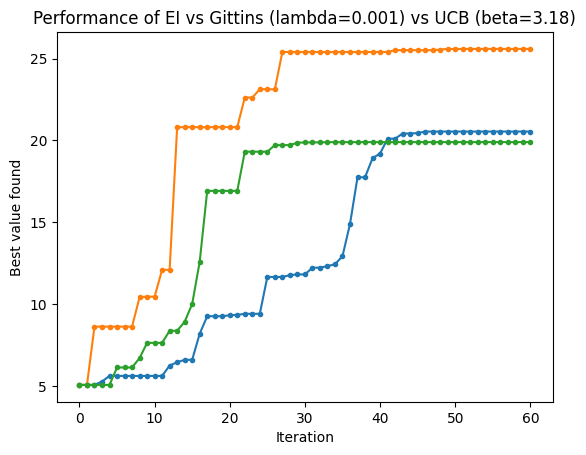

In [317]:
cost=0.001
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
plt.plot(UCB_best_dict[beta],'.-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI vs Gittins (lambda={}) vs UCB (beta={})".format(cost, beta))

Text(0.5, 1.0, 'Performance of EI vs Gittins vs UCB on FreeSolv Data')

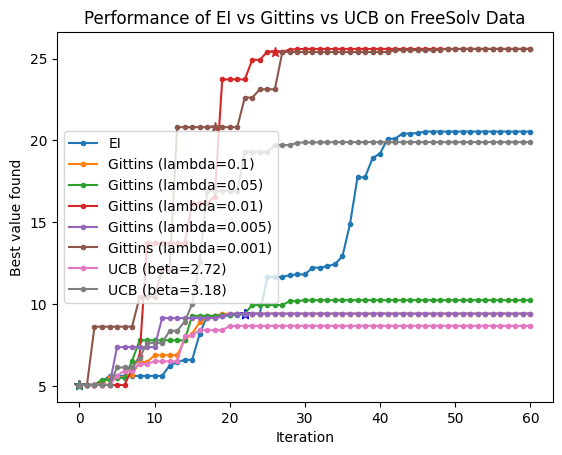

In [318]:
# Plotting EI
plt.plot(EI_best, '.-', label='EI')

# Plotting Gittins
for cost in sorted(GI_best_dict.keys(), reverse=True):
    EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
    plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
    line = plt.plot(GI_best_dict[cost], '.-', label="Gittins (lambda={})".format(cost))
    if np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0].size > 0:
        GI_stopping_time = np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0][0]
        plt.scatter(GI_stopping_time, GI_best_dict[cost][GI_stopping_time], c=line[0].get_color(), marker='*', s=50)

# Plotting UCB
plt.plot(UCB_best_dict[2.72], '.-', label="UCB (beta={})".format(2.72))
plt.plot(UCB_best_dict[3.18], '.-', label="UCB (beta={})".format(3.18))
    
# Adding legend
plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI vs Gittins vs UCB on FreeSolv Data")